# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize subsets of your data, then track how those subsets change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import cytoflow as flow

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   coarse_events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about a subset of the data.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute those geometric means with the `ChannelStatisticOp` operation:

In [3]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset.  The result is stored in the `statistics` attribute of the `Experiment` that it returns:

In [4]:
ex2.statistics

{('ByIP', 'geom_mean'): IP
 0.0159     105.163753
 0.0211     140.752878
 0.0282     166.437993
 0.0376     191.374816
 0.0500     261.832068
 0.0668     408.787006
 0.0892     675.174176
 0.1188     923.079660
 0.1584    1271.577736
 0.2112    1168.979200
 0.2816    1550.334433
 0.3754    1739.073598
 0.5000    1787.951152
 0.6674    2217.305297
 0.8899    2362.443238
 1.1865    2447.723183
 1.5820    2451.186981
 2.1090    2464.562061
 2.8125    2444.044854
 3.7500    2453.548783
 5.0000    2337.998059
 dtype: float64}

The `statistics` attribute is a dictionary.  The keys are tuples, where the first element in the tuple is the name of the operation that created the statistic, and the second element is specific to the operation.  The `Statistics1DOp` operation sets the second element of the tuple to the function name.  (You can override this by setting `Statistics1DOp.statistic_name`; this is useful if `function` is a lambda function.)

In [5]:
ex2.statistics.keys()

[('ByIP', 'geom_mean')]

The value of each entry in `Experiment.statistics` is a `pandas.Series`.  The series index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [6]:
ex2.statistics[('ByIP', 'geom_mean')]

IP
0.0159     105.163753
0.0211     140.752878
0.0282     166.437993
0.0376     191.374816
0.0500     261.832068
0.0668     408.787006
0.0892     675.174176
0.1188     923.079660
0.1584    1271.577736
0.2112    1168.979200
0.2816    1550.334433
0.3754    1739.073598
0.5000    1787.951152
0.6674    2217.305297
0.8899    2362.443238
1.1865    2447.723183
1.5820    2451.186981
2.1090    2464.562061
2.8125    2444.044854
3.7500    2453.548783
5.0000    2337.998059
dtype: float64

We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [8]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics[("ByIP", "geom_mean")][0:12]

IP      Replicate
0.0159  1            106.101551
        2            103.120228
        3            106.282060
0.0211  1            145.905671
        2            135.743706
        3            140.792647
0.0282  1            168.756080
        2            170.291822
        3            160.436873
0.0376  1            185.326086
        2            203.545967
        3            185.804103
dtype: float64

Note that the `pandas.Series` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [9]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP").plot(ex2)

CytoflowViewError: Must use all the statistic indices as variables or facets: [u'IP', u'Replicate']

Oops!  Whenever we plot a statistic, we have to use *all* of the variables that were used to subdivide the experiment.  If the `Statistics1DOp` above had `by = ["IP", "Replicate"]`, then both `IP` and `Replicate` must either a plot variable or a plot facet.  Let's try it again:

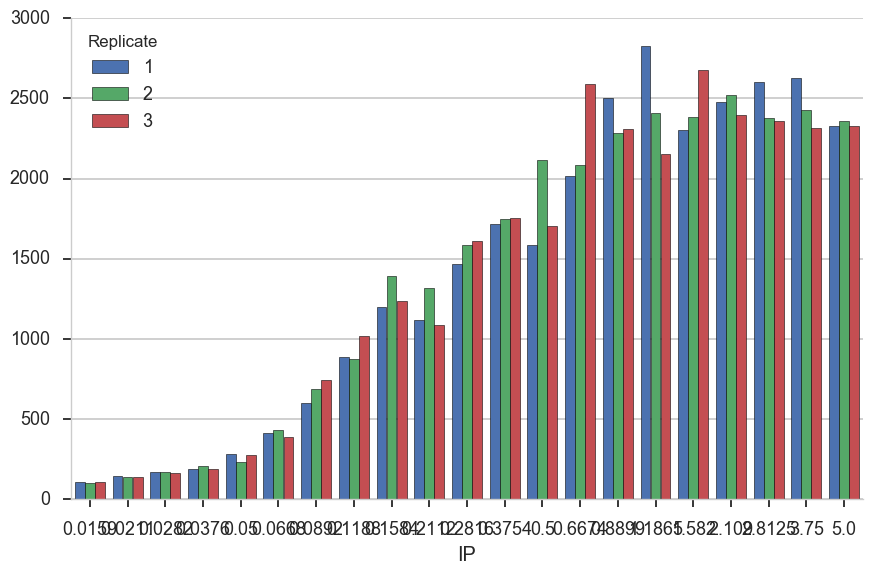

In [10]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

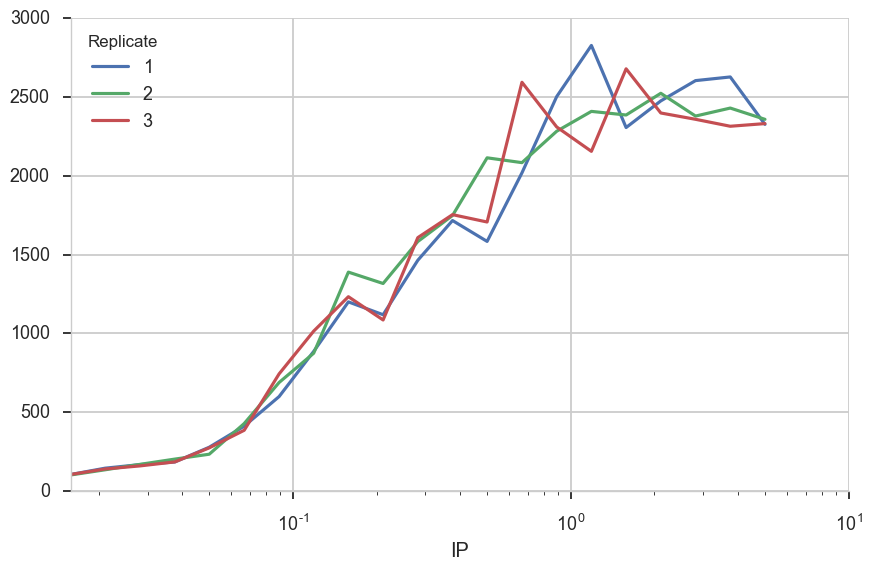

In [11]:
flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = 'log',
                 huefacet = "Replicate").plot(ex2)

Statistics views can also plot error bars; the error bars must *also* be a statistic, and they must have the same indices as the "main" statistic.  For example, let's plot the geometric mean and geometric standard deviation of each IP subset:

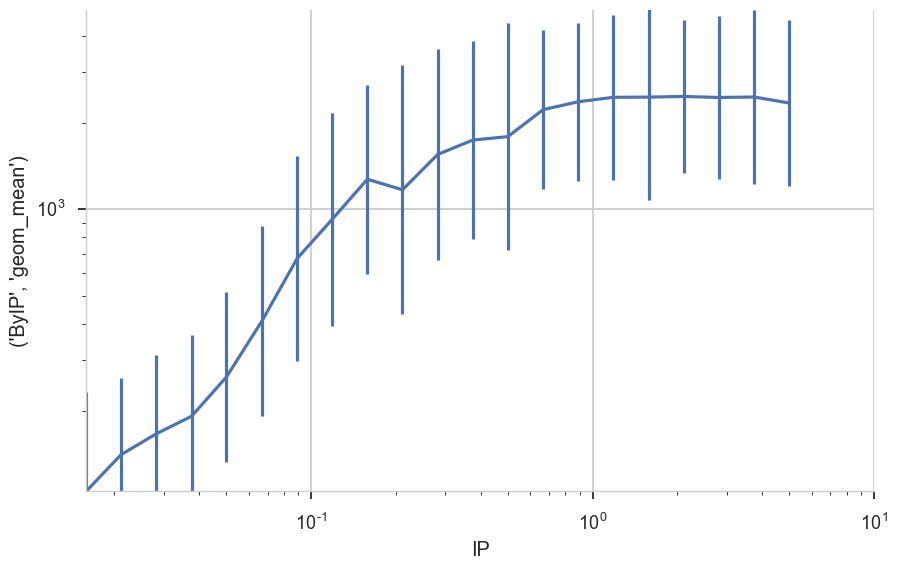

In [17]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd_range).apply(ex2)

flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = "log",
                 yscale = "log",
                 error_statistic = ("ByIP", "geom_sd_range")).plot(ex3)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis.  We can also plot two statistics against eachother.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

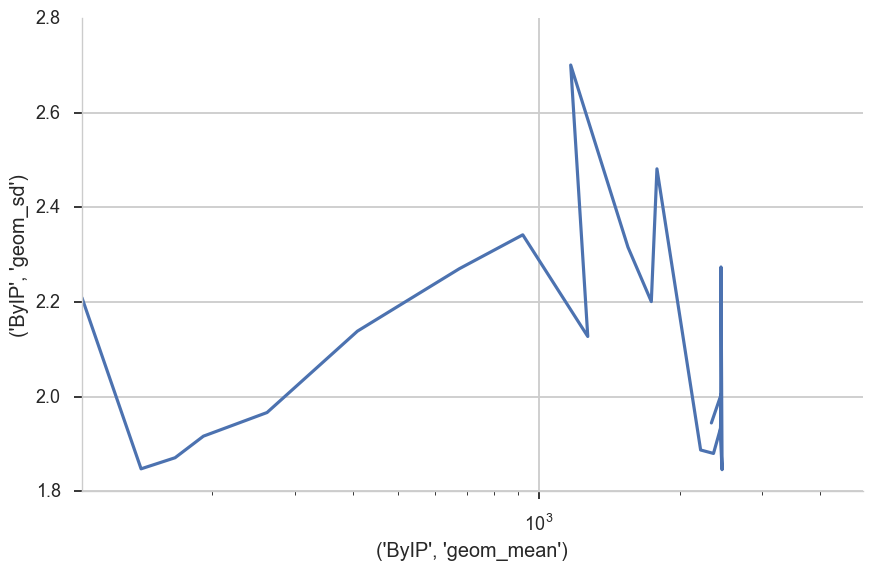

In [21]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd).apply(ex2)

flow.Stats2DView(variable = "IP",
                 xstatistic = ("ByIP", "geom_mean"),
                 ystatistic = ("ByIP", "geom_sd"),
                 xscale = "log").plot(ex3)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too.  For example, the `GaussianMixture1DOp` adds several statistics for each component of the mixture model it fits, containing the mean, standard deviation and proportion of observations in each component:
